# Mini-Project: SVM & LR Classification
### Ryan Bass, Brett Benefield, Cho Kim, Nicole Wittlin

<span style="color: blue">Remove all blue text before submitting</span>

In [125]:
%matplotlib inline
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import scatter_matrix
from IPython.display import HTML, display
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, SelectKBest, chi2, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

In [126]:
verboseStatus = False

In [127]:
# Brett's directory
# Desktop
#%cd "C:\Sandbox\SMU\dataMining\ChoRepo\EducationDataNC\2017\Machine Learning Datasets"
# Laptop
#%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory. Either uncomment the cd statement above or make your own cd.
#%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directorY 
#%cd "C:\Users\Nicole Wittlin\Documents\7331DataMining\EducationDataNC\2017\Raw Datasets"
dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

print('********* Initial Values Before Cleaning *******************')
dfPublicHS.info(verbose = verboseStatus)

C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets
********* Initial Values Before Cleaning *******************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Columns: 403 entries, student_num to unit_code
dtypes: float64(322), int64(81)
memory usage: 1.4 MB


In [128]:
# Credit: https://www.kaggle.com/saravanann/santander
# Drop any columns that have zero variance
totalColNum = dfPublicHS.shape[1]
sel = VarianceThreshold()
sel.fit(dfPublicHS)

keepCols = sel.get_support(indices=True)
dfColIndex = np.arange(dfPublicHS.columns.size)
dropCol = np.delete(dfColIndex, keepCols)
dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)

In [111]:
# Drop any columns that the value is the same for 90% of the records
#sel = VarianceThreshold(.90 * (1 - .90))
#sel.fit(dfPublicHS)
#keepCols = sel.get_support(indices=True)
#dfColIndex = np.arange(dfPublicHS.columns.size)
#dropCol = np.delete(dfColIndex, keepCols)
#dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)
#dfPublicHS.shape

In [129]:
# store all column names to a list
colNames = dfPublicHS.columns.tolist()

# Create correlation matrix
dfCorr = dfPublicHS[colNames].corr('pearson').abs()

# print correlation matrix
dfCorr

,student_num,lea_avg_student_num,st_avg_student_num,09_Size,10_Size,11_Size,12_Size,Biology_Size,English II_Size,Math I_Size,...,SRC_Grades_Devices_Sent_Home_6:07:08,SRC_Grades_Devices_Sent_Home_6:7:8:9:10:11:12,SRC_Grades_Devices_Sent_Home_6:7:8:9:10:11:12:13,SRC_Grades_Devices_Sent_Home_8:9:10:11:12:13,SRC_Grades_Devices_Sent_Home_9:10,SRC_Grades_Devices_Sent_Home_9:10:11,SRC_Grades_Devices_Sent_Home_9:10:11:12,SRC_Grades_Devices_Sent_Home_9:10:11:12:13,SRC_Grades_Devices_Sent_Home_9:10:12,unit_code
student_num,1.000000,0.577813,0.158654,0.482427,0.545790,0.622973,0.602696,0.651012,0.542595,0.504443,...,0.006434,0.068748,0.050118,0.053001,0.038277,0.020877,0.044087,0.307002,0.040069,0.095413
lea_avg_student_num,0.577813,1.000000,0.266009,0.227217,0.256996,0.256629,0.241507,0.415685,0.292036,0.272326,...,0.059568,0.109862,0.081064,0.083629,0.018843,0.060824,0.172195,0.116165,0.064520,0.169113
st_avg_student_num,0.158654,0.266009,1.000000,0.133943,0.113514,0.185630,0.213359,0.229118,0.171302,0.115240,...,0.083580,0.373113,0.263549,0.009292,0.009292,0.026481,0.006265,0.058825,0.009292,0.063130
09_Size,0.482427,0.227217,0.133943,1.000000,0.712800,0.592155,0.554159,0.540738,0.477195,0.587350,...,0.001953,0.075839,0.009608,0.100266,0.031583,0.066520,0.023474,0.251240,0.015102,0.050861
10_Size,0.545790,0.256996,0.113514,0.712800,1.000000,0.633552,0.594540,0.594721,0.546398,0.479184,...,0.042601,0.081432,0.017624,0.017624,0.087442,0.019057,0.062975,0.294168,0.002324,0.033635
11_Size,0.622973,0.256629,0.185630,0.592155,0.633552,1.000000,0.790071,0.601437,0.514401,0.508646,...,0.041734,0.075168,0.089832,0.089832,0.016359,0.059943,0.078185,0.330737,0.000614,0.000788
12_Size,0.602696,0.241507,0.213359,0.554159,0.594540,0.790071,1.000000,0.548973,0.480256,0.486297,...,0.046796,0.071525,0.077970,0.077970,0.001879,0.046245,0.081762,0.402232,0.001879,0.050470
Biology_Size,0.651012,0.415685,0.229118,0.540738,0.594721,0.601437,0.548973,1.000000,0.728654,0.599181,...,0.025074,0.094739,0.050517,0.050517,0.025913,0.086837,0.022969,0.140187,0.017711,0.048523
English II_Size,0.542595,0.292036,0.171302,0.477195,0.546398,0.514401,0.480256,0.728654,1.000000,0.617556,...,0.041859,0.111418,0.066417,0.009095,0.009095,0.064511,0.038768,0.130433,0.033662,0.050935
Math I_Size,0.504443,0.272326,0.115240,0.587350,0.479184,0.508646,0.486297,0.599181,0.617556,1.000000,...,0.041099,0.088183,0.033329,0.016558,0.000071,0.015011,0.016565,0.146079,0.016700,0.005566


In [130]:
## source for code below: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/ ##

# Select upper triangle of correlation matrix
upper = dfCorr.where(np.triu(np.ones(dfCorr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
to_drop
print (len(to_drop))

124


In [114]:
# code to determine the number of highly correlated variables to drop for given r.
r = .95
while (r >= .80):
    to_drop = [column for column in upper.columns if any(upper[column] > r)]
    print('For r of ', r, 'drop # is:', len(to_drop) )
    r = r-.01
    r = round(r,2)
# print the list of columns to drop for the last iteration of the while loop.    
to_drop

## I can't get this to work!! Uncomment it to see the error##
#dfDropped = dfPublicHS.drop(to_drop, axis=1)

For r of  0.95 drop # is: 0
For r of  0.94 drop # is: 11
For r of  0.93 drop # is: 22
For r of  0.92 drop # is: 28
For r of  0.91 drop # is: 34
For r of  0.9 drop # is: 42
For r of  0.89 drop # is: 51
For r of  0.88 drop # is: 58
For r of  0.87 drop # is: 66
For r of  0.86 drop # is: 72
For r of  0.85 drop # is: 80
For r of  0.84 drop # is: 88
For r of  0.83 drop # is: 99
For r of  0.82 drop # is: 107
For r of  0.81 drop # is: 116
For r of  0.8 drop # is: 124


['lea_state_perpupil_num',
 '4-Year Cohort Graduation Rate Score',
 'ACTMath_ACTBenchmark_All',
 'ACTScience_ACTBenchmark_All',
 'ACTWorkKeys_SilverPlus_All',
 'ACTWriting_ACTBenchmark_All',
 'EOCSubjects_CACR_All',
 'ACTCompositeScore_UNCMin_Female',
 'ACTEnglish_ACTBenchmark_Female',
 'ACTMath_ACTBenchmark_Female',
 'ACTReading_ACTBenchmark_Female',
 'ACTScience_ACTBenchmark_Female',
 'ACTWorkKeys_SilverPlus_Female',
 'EOCBiology_CACR_Female',
 'EOCEnglish2_CACR_Female',
 'GraduationRate_5yr_Female',
 'ACTCompositeScore_UNCMin_Male',
 'ACTMath_ACTBenchmark_Male',
 'ACTScience_ACTBenchmark_Male',
 'ACTWorkKeys_SilverPlus_Male',
 'ACTWriting_ACTBenchmark_Male',
 'EOCBiology_CACR_Male',
 'EOCEnglish2_CACR_Male',
 'EOCMathI_CACR_Male',
 'ACTMath_ACTBenchmark_AmericanIndian',
 'ACTWorkKeys_SilverPlus_AmericanIndian',
 'ACTWriting_ACTBenchmark_AmericanIndian',
 'EOCBiology_CACR_AmericanIndian',
 'EOCEnglish2_CACR_AmericanIndian',
 'EOCMathI_CACR_AmericanIndian',
 'GraduationRate_4yr_Americ

In [131]:
dfDropped = dfPublicHS.drop(to_drop, axis = 1)
dfDropped.describe()

,student_num,lea_avg_student_num,st_avg_student_num,09_Size,10_Size,11_Size,12_Size,Biology_Size,English II_Size,Math I_Size,...,grades_1_to_1_access_9:10:11:12,grades_1_to_1_access_9:10:11:12:13,grades_1_to_1_access_9:11:12:13,SRC_Grades_Devices_Sent_Home_10:11:12,SRC_Grades_Devices_Sent_Home_10:11:12:13,SRC_Grades_Devices_Sent_Home_6:7:8:9:10:11:12,SRC_Grades_Devices_Sent_Home_8:9:10:11:12:13,SRC_Grades_Devices_Sent_Home_9:10,SRC_Grades_Devices_Sent_Home_9:10:12,unit_code
count,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,...,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,834.336170,823.078723,833.417021,18.251064,17.534043,17.117021,15.623404,18.159574,19.110638,17.991489,...,0.325532,0.078723,0.002128,0.004255,0.004255,0.004255,0.002128,0.002128,0.002128,513869.680851
std,593.357073,360.428092,97.416634,8.414169,9.269129,8.807896,9.262385,5.636281,5.644826,5.559518,...,0.469073,0.269594,0.046127,0.065163,0.065163,0.065163,0.046127,0.046127,0.046127,282797.834670
min,8.000000,105.000000,278.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10303.000000
25%,312.750000,577.000000,853.000000,16.000000,15.000000,14.000000,11.000000,15.000000,17.000000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,280307.000000
50%,758.500000,810.000000,853.000000,20.000000,20.000000,20.000000,18.000000,19.000000,20.000000,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,505332.000000
75%,1208.500000,974.000000,853.000000,23.000000,23.000000,24.000000,22.000000,22.000000,23.000000,21.750000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,770348.750000
max,2966.000000,1852.000000,853.000000,94.000000,92.000000,30.000000,36.000000,30.000000,30.000000,32.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,995330.000000


In [116]:
dfDropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Columns: 278 entries, student_num to unit_code
dtypes: float64(206), int64(72)
memory usage: 1020.9 KB


In [117]:
dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'].describe()

count    470.000000
mean      49.407119
std       16.665647
min        0.000000
25%       43.469064
50%       52.178615
75%       59.198851
max       89.583333
Name: ALL_All Students (Total or Subtotal_ENROLL_sch_pct, dtype: float64

In [132]:
# Evenly split our target variable (predict whether a school will have 52% postsecondary enrollment)
splitLimit = dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'].median()
dfDropped['schoolPctTarget'] = np.where(dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'] >= splitLimit, 1, 0)
print("{} of {}: {}%".format(dfDropped['schoolPctTarget'].sum(), dfDropped.shape[0], 
                             round(dfDropped['schoolPctTarget'].sum()/dfDropped.shape[0] * 100,2)))

235 of 470: 50.0%


In [133]:
# Credit: https://www.kaggle.com/saravanann/santander

# Normalize data
maxCols = dfDropped.shape[1]
X = scale_data(dfDropped.iloc[:,0:maxCols-2])

# Set target
y = dfDropped['schoolPctTarget']

C:\Users\Clovis\Anaconda3\envs\three.six\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Clovis\Anaconda3\envs\three.six\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [120]:
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(dfDropped, 150))

Top Absolute Correlations
0-3 Years_LEA_Exp_Pct_Prin               4-10 Years_LEA_Exp_Pct_Prin                 0.797797
English II Score                         Biology Score                               0.797757
EOCBiology_CACR_AIG                      EOCEnglish2_CACR_AIG                        0.797197
EOCBiology_CACR_White                    EOCEnglish2_CACR_White                      0.796692
lea_tchyrs_0thru3_pct                    lea_tchyrs_11plus_pct                       0.794785
SPG Score                                ACT Score                                   0.792991
11_Size                                  12_Size                                     0.790071
flicensed_teach_pct                      lateral_teach_pct                           0.789431
NC Math 1 Score                          English II Score                            0.788645
GraduationRate_4yr_Asian                 GraduationRate_5yr_Asian                    0.786780
ACTCompositeScore_UNCMin_Asian    

In [134]:
# Choose the top 10% attributes based on ANOVA score
sel = SelectPercentile(f_classif, percentile = 10)
sel.fit(X, y)

# Credit: https://www.kaggle.com/saravanann/santander
# Convert back to dataframe

keepCols = sel.get_support(indices=True)
temp = sel.transform(X)
X = pd.DataFrame(temp, columns = X.columns[keepCols])

In [135]:
from sklearn.model_selection import ShuffleSplit

# delete continuous variable that was turned into categorical
if 'ALL_All Students (Total or Subtotal_ENROLL_sch_pct' in dfDropped:
    del dfDropped['ALL_All Students (Total or Subtotal_ENROLL_sch_pct']

# we want to predict the X and y data as follows:
if 'schoolPctTarget' in dfPublicHSlr:
    y = dfDropped['schoolPctTarget'].values # get the labels we want
    del dfDropped['schoolPctTarget'] # get rid of the class label
    X = dfDropped.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)


In [136]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l1', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

KeyError: '[ 43 258 437 173 377  39 449  84 115 240 440 267 205 232 388 239 290 400\n 296   5 229  32 365 453  59  27 362 255 379 278 465 209 140 395 210 207\n  24 277 293 370  82 190 364 390  13 178 174  29 256 162  56  15 133 233\n 383 111  64 261 227 202  79 170 325 120 326 182 430 168 399  19 378 201\n 414 289 101 156   9 461  97 335 288 314 340 206 260 245 280 172 163 228\n  28 301  94 294  44 199 452 358 208 193 319 185 467  65  81 469 247 339\n 271  69  76 462 241 368 197  42 285 128 103 217 459 315 158 281 222 181\n 421 112 327 234 445 146 343  89 433  63 195 419 420 223 455 286 141  90\n 265 443 109 426 321 468 424 152 151  70 102 320  26 274  40 145 192 402\n 407  50  51 130 447 250 155 116  10 348 382  61   1 373 262 177 423 283\n 252 308 194 214  16  78 300  96 369 123 231 354 139  11  48  30 218 413\n 295  21 242 331  75   0 230 107 417   7  88 352 186  66 312 394  52 160\n 237   6 132 406 375 171  37 183 273 403 166  87 243 347 356 330 317 149\n 268 344 431  86 150  62 359 216 444  18 408 307 332 279 346 456 404 425\n 428 161 298  25 391  73 276 411 311 392 350 200  71 374 253 235  85 345\n  20 405  92 351 418 248  72 322 259  38 169 291  57 328  77  67 114 416\n 299 148 219 134  47   4 244 303 363 393 225  54 249 167 142 104 397 385\n 387  91 316 334  33 147 329 187 221 448 204 119  12 410 138 164 180 272\n 349 371  74 246 257  68 270 264  60 355 263 203 213 451 458 284 143 121\n  53 106 466  36  46 188 384 438  45 282 439 198 353 432 323 442 357   2\n 122 422 179 305 450  83 165 176 446 226  31 463  55   3 396 427] not in index'

In [70]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,dfPublicHSlr.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

C:\Users\Clovis\Anaconda3\envs\three.six\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy: 0.8617021276595744
[[38  7]
 [ 6 43]]
PacificIslandFemalePct has weight of -0.24105017458090472
lea_advance_dgr_pct has weight of -0.21043416611606972
pct_eds has weight of -0.17768313987665704
GraduationRate_4yr_SWD has weight of -0.1764098204013588
EOCEnglish2_CACR_TwoorMoreRaces has weight of -0.16661064209639087
PacificIslandPct has weight of -0.16393622484362289
wap_per_classroom has weight of -0.14887039965630375
books_per_student has weight of -0.14220879991803367
lea_total_expense_num has weight of -0.1332742342260407
GraduationRate_4yr_Asian has weight of -0.1299794967719234
GraduationRate_4yr_LEP has weight of -0.12871695088075563
EVAAS Growth Status_Met has weight of -0.12797987736603075
ACTWriting_ACTBenchmark_AmericanIndian has weight of -0.12398214316305259
grade_range_cd_8-12 has weight of -0.1239235656224486
lea_services_expense_pct has weight of -0.12177003871999245
GraduationRate_5yr_EDS has weight of -0.12086806227299085
grade_range_cd_PK-12 has weight of -

still 401 explanatory variables at the moment, need to figure out how to knock a lot out. L1 (lasso regression) gave about 2% increase in accuracy compared to L2 (ridge regression). but that could just be due to randomness if we re-ran them a few more times. also need to figure out GridSearchCV for the costs on this one.

In [71]:
len(zip_vars)

401

## Create Models (50 points)
<span style="color: blue">Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). <b>Adjust parameters of the models to make them more accurate.</b> If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.

## Support Vector Machines

In [8]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()
    
def getTopCoefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    feature_names = np.array(feature_names)
    return feature_names[top_coefficients]

# Source: https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def percentile_threshold_selector(data, percent=10):
    selector = SelectPercentile(f_classif, percentile = percent)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def scale_data(data):
    scaler = StandardScaler()
    temp = scaler.fit_transform(data)
    data = pd.DataFrame(temp, columns = data.columns)
    return data

In [9]:
param_grid = [ {'C': [1, 10, 100, 1000], 'kernel': ['linear']} ]
cls = GridSearchCV(SVC(), param_grid, cv=10)

In [10]:
# Evenly split our target variable (predict whether a school will have 52% postsecondary enrollment)
splitLimit = 52
dfPublicHS['schoolPctTarget'] = np.where(dfPublicHS['ALL_All Students (Total or Subtotal_ENROLL_sch_pct'] >= splitLimit, 1, 0)
print("{} of {}: {}%".format(dfPublicHS['schoolPctTarget'].sum(), dfPublicHS.shape[0], 
                             round(dfPublicHS['schoolPctTarget'].sum()/dfPublicHS.shape[0] * 100,2)))

239 of 470: 50.85%


### Column preparation

In [11]:
# Credit: https://stackoverflow.com/questions/19758364/rename-a-single-column-header-in-a-pandas-dataframe
# Credit: https://stackoverflow.com/questions/21606987/how-can-i-strip-the-whitespace-from-pandas-dataframe-headers
# Credit: https://stackoverflow.com/questions/39741429/pandas-replace-a-character-in-all-column-names
# Credit: https://stackoverflow.com/questions/33157643/pandas-replace-erase-different-characters-from-strings

# Drop these columns because they contain the answer we are trying to predict
dropCols = dfPublicHS.filter(regex = r'sch_pct|college')

# These names seem to cause problems so let's give them friendlier names
renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
              '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
              '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
              '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
              '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
              '_1_to_1_access_Yes': 'one_to_one_access_yes'}

# Drop columns
dfPublicHS.drop(dropCols, axis = 1, inplace = True)

# Remove any trailing white spaces
dfPublicHS.columns = dfPublicHS.columns.str.strip()

# Remove any spaces, slashes, or hyphens
dfPublicHS.columns = dfPublicHS.columns.str.replace(r' |/|-', "_")

# Rename columns
dfPublicHS.rename(columns=renameCols, inplace = True)

### Normalize Data

In [12]:
# Credit: https://www.kaggle.com/saravanann/santander

# Normalize data
maxCols = dfPublicHS.shape[1]
X = scale_data(dfPublicHS.iloc[:,0:maxCols-2])

# Set target
y = dfPublicHS['schoolPctTarget']

C:\Users\Clovis\Anaconda3\envs\three.six\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Clovis\Anaconda3\envs\three.six\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Feature Selection

In [14]:
# Choose the top 10% attributes based on ANOVA score
sel = SelectPercentile(f_classif, percentile = 10)
sel.fit(X, y)

# Credit: https://www.kaggle.com/saravanann/santander
# Convert back to dataframe

keepCols = sel.get_support(indices=True)
temp = sel.transform(X)
X = pd.DataFrame(temp, columns = X.columns[keepCols])

In [15]:
# Create a test and train dataset with an 80/20 split
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2)

In [16]:
# Train SVM model
print("Training started at: {}".format(datetime.now().time()))
%time cls.fit(xTrain, yTrain)

print("Best parameters set found on development set:")
print()
print(cls.best_params_)
print()
print("Grid scores on development set:")
print()
means = cls.cv_results_['mean_test_score']
stds = cls.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cls.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Training started at: 10:22:01.265827


C:\Users\Clovis\Anaconda3\envs\three.six\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 4min 11s
Best parameters set found on development set:

{'C': 100, 'kernel': 'linear'}

Grid scores on development set:

0.707 (+/-0.111) for {'C': 1, 'kernel': 'linear'}
0.713 (+/-0.122) for {'C': 10, 'kernel': 'linear'}
0.721 (+/-0.121) for {'C': 100, 'kernel': 'linear'}
0.721 (+/-0.123) for {'C': 1000, 'kernel': 'linear'}



In [17]:
# Predict test values
yhat = cls.predict(xTest)

In [18]:
# Show model performance
print(confusion_matrix(yTest, yhat))
print(classification_report(yTest, yhat))

[[32 18]
 [10 34]]
              precision    recall  f1-score   support

           0       0.76      0.64      0.70        50
           1       0.65      0.77      0.71        44

   micro avg       0.70      0.70      0.70        94
   macro avg       0.71      0.71      0.70        94
weighted avg       0.71      0.70      0.70        94



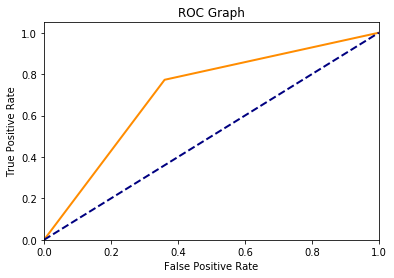

In [19]:
# Plot an ROC Graph
fpr, tpr, thresholds = roc_curve(yTest, yhat)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.show()

In [22]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

# Graph the columns in terms of prediction weight
cv = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1,1), max_df=1.0, min_df=1)
cv.fit(xTrain)

plot_coefficients(cls, cv.get_feature_names())

AttributeError: 'GridSearchCV' object has no attribute 'coef_'

In [118]:
topFeatureList3 = np.append(topFeatureList2, getTopCoefficients(cls, cv.get_feature_names()))
print(len(topFeatureList3))

120


In [149]:
dfTemp = dfPublicHS.filter(items = topFeatureList, axis = 1)
dfTemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 2 columns):
lea_state_perpupil_num      470 non-null float64
lea_supplies_expense_pct    470 non-null float64
dtypes: float64(2)
memory usage: 7.4 KB


In [ ]:
# Source: https://stackoverflow.com/questions/34649969/how-to-find-the-features-names-of-the-coefficients-using-scikit-linear-regressio
coef_dict = {}
for coef, feat in zip(cls.coef_[0,:], X.columns):
    coef_dict[feat] = coef

for key, value in coef_dict.items():
    #print(key, value)

In [ ]:
# Cool Plot
# http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#example-svm-plot-separating-hyperplane-py

## Model Advantages (10 points)
<span style="color: blue">Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.</span>

## Interpret Feature Importance (30 points)

<span style="color: blue">Use the weights from logistic regression to interpret the importance of different features for the classification task. <b>Explain your interpretation in detail.</b>Why do you think some variables are more important?

## Interpret Support Vectors (10 points)
<span style="color:blue">Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.